## 概要
priorとlikelihoodに関する情報をコードしているニューロンの役割分担がどの程度行われているのかを定量化する。

あるニューロンの時間発展 $x(t)$ を考える。環境変化を $E(t)$ とする。

- likelihoodのcoding率: 同一のEにおける $x(t)$ の分散 $\langle x^2\rangle - \langle x\rangle^2 $の異なるEに関する平均
- priorのcoding率: 同一のEにおける$x(t)$の平均$[x(t)]$の異なるEに関する分散

In [1]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [37]:
state_list = [
    State(mu=0.5, sigma=0.04),
    State(mu=0.5, sigma=0.3),
    State(mu=0.5, sigma=0.04),
    State(mu=0.5, sigma=0.8),
]

In [38]:
def make_signal(N, time_length, state_list, uncertainty=0.5):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state_list[(t // 40) % 3]()
            true_signal_list[i, t] = true_signal
            # true_signal = state_list[2]()
            g = 2
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * 1 * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        # signal_mu_list.append(signal_mu)
        
    return input_signals, true_signal_list, signal_mu_list

In [39]:
config_path = '../slow_reservoir/trained_model/dynamic_state/20220423_2/20220423_2.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state/{model_name}/epoch_400.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220423_2


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [40]:
sample_num = 1000
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=120, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))
             

# priorなしのモデルによる推論
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs, prior_list, reservoir_list = model(inputs, hidden, reservoir, 120)                                                     
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()


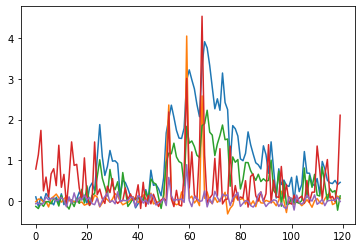

In [41]:
plt.plot(neural_dynamics[0, :, 129])
plt.plot(neural_dynamics[0, :, 8])
plt.plot(neural_dynamics[0, :, 120])
plt.plot(neural_dynamics[0, :, 14])
plt.plot(neural_dynamics[0, :, 16])

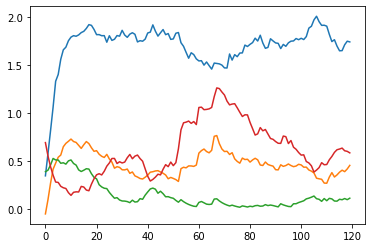

In [42]:
plt.plot(reservoir_dynamics[0, :, 6])
plt.plot(reservoir_dynamics[0, :, 1])
plt.plot(reservoir_dynamics[0, :, 8])
plt.plot(reservoir_dynamics[0, :, 40])

### Calculation

In [43]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = neural_dynamics[:, i*40:(i+1)*40, 6].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))

In [44]:
np.mean(var_activity_list) / np.var(mean_activity_list)

4702.5728

In [45]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = neural_dynamics[:, i*40:(i+1)*40, 0].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

14482.333


In [46]:
np.max(E_time_series)

0.40884352

In [47]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = neural_dynamics[:, i*40:(i+1)*40, 13].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

85.27148


In [48]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = neural_dynamics[:, i*40:(i+1)*40, 16].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

3105.6047


In [49]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = reservoir_dynamics[:, i*40:(i+1)*40, 1].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

11.324573


In [50]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = reservoir_dynamics[:, i*40:(i+1)*40, 0].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

18745.75


In [51]:
var_activity_list = []
mean_activity_list = []
for i in range(3):
    E_time_series = reservoir_dynamics[:, i*40:(i+1)*40, 3].reshape(1000*40)
    var_activity_list.append(np.var(E_time_series))
    mean_activity_list.append(np.mean(E_time_series))
    
print(np.mean(var_activity_list) / np.var(mean_activity_list))

1502.3839


In [52]:
np.max(neural_dynamics[:, :, 0])

0.7646691

#### fast neuron側

In [53]:
coding_ratio_dict = {}
for i in range(cfg['MODEL']['SIZE']):
    if np.max(neural_dynamics[:, :, i]) < 1:
        continue
    var_activity_list = []
    mean_activity_list = []
    for j in range(3):
        E_time_series = neural_dynamics[:, j*40:(j+1)*40, i].reshape(1000*40)
        var_activity_list.append(np.var(E_time_series))
        mean_activity_list.append(np.mean(E_time_series))
       
    coding_ratio = np.mean(var_activity_list) / np.var(mean_activity_list)
    if coding_ratio >= 20:
        continue
    coding_ratio_dict[i] = np.mean(var_activity_list) / np.var(mean_activity_list)

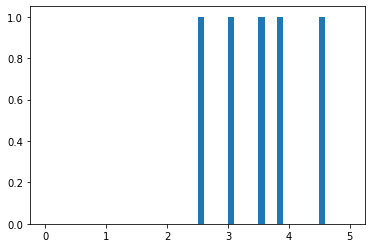

In [54]:
plt.hist(coding_ratio_dict.values(), bins=50, range=(0, 5))
plt.show()

#### sub-network側

In [55]:
reservoir_coding_ratio_dict = {}
for i in range(cfg['MODEL']['RESERVOIR']):
    if np.max(reservoir_dynamics[:, :, i]) < 1:
        continue
    var_activity_list = []
    mean_activity_list = []
    for j in range(3):
        E_time_series = reservoir_dynamics[:, j*40:(j+1)*40, i].reshape(1000*40)
        var_activity_list.append(np.var(E_time_series))
        mean_activity_list.append(np.mean(E_time_series))
       
    coding_ratio = np.mean(var_activity_list) / np.var(mean_activity_list)
    if coding_ratio >= 20:
        continue
    reservoir_coding_ratio_dict[i] = np.mean(var_activity_list) / np.var(mean_activity_list)

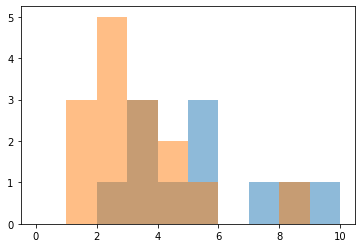

In [58]:
plt.hist(coding_ratio_dict.values(), bins=10, range=(0, 10), alpha=0.5)
plt.hist(reservoir_coding_ratio_dict.values(), bins=10, range=(0, 10), alpha=0.5)
plt.show()

In [57]:
coding_ratio_dict

{4: 16.444723,
 9: 10.407094,
 34: 16.408588,
 47: 8.242886,
 60: 9.566438,
 65: 5.6887674,
 95: 16.0624,
 102: 5.599483,
 119: 3.5169795,
 120: 3.8785038,
 123: 5.6291656,
 124: 10.838609,
 129: 2.5468342,
 130: 10.483935,
 142: 14.570848,
 149: 11.362891,
 157: 4.5913086,
 167: 10.399809,
 176: 7.5550222,
 182: 3.033492,
 194: 18.370947}

In [35]:
reservoir_coding_ratio_dict

{1: 8.424456,
 6: 7.806266,
 8: 1.3348302,
 9: 5.168859,
 13: 1.1712748,
 17: 0.89356244,
 27: 2.51993,
 29: 5.5414834,
 30: 3.4365036,
 32: 1.2391472,
 33: 0.64312536,
 34: 0.4662935,
 35: 4.546995,
 37: 0.78705907,
 38: 4.2961817,
 39: 3.6624198,
 40: 0.42262542,
 41: 12.304073,
 47: 2.2231982,
 49: 2.5140595}